In [ ]:
from __future__ import division

import os
import operator
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

from utils import *
from skimage import transform 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam

# share GPU
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.49
set_session(tf.Session(config=config))

%matplotlib inline

In [33]:
# data constants
max_size = (32, 32, 1)
data_files = {'cifar': '../data/cifar.npy',
              'mnist': '../data/mnist.npy',
              'lfw': '../data/lfw.npy'}

# load and transform data
data = np.load(data_files['mnist'])
data = data.astype('float32')

if data.shape[1:3] > max_size:
    data = np.array([transform.resize(image, max_size, preserve_range=True, order=0)] 
                    for image in data)

# shuffle data
np.random.shuffle(data)

# 
data_count = data.shape[0]
data_size = data.shape[1:4] if data.shape[3] > 1 else data.shape[1:3]
data_dim = reduce(operator.mul, data.shape[1:])

print 'Loaded data {}'.format(data.shape)

Loaded data (70000, 28, 28, 1)


In [36]:
data_mean = data.mean(axis=0, keepdims=True)
data_std = data.std(axis=0, keepdims=True) + 1e-16
data_proc = (data - data_mean) / data_std

print 'Before preproc', data.min(), data.max()
print 'After preproc', data_proc.min(), data_proc.max()

Before preproc 0.0 255.0
After preproc -1.27798 264.575


In [15]:
# latent space generators
def get_uniform_space(high, low, space_size):
    return lambda batch_size: np.random.uniform(low, high, (batch_size, space_size)).astype('float32')

def get_gaussian_space(mean, var, space_size):
    return lambda batch_size: np.random.normal(mean, var, (batch_size, space_size)).astype('float32')

In [30]:
def get_mlp_model(input_dim):
    # setup optimizer
    d_opt = SGD(lr=0.01, momentum=0.05)
    g_opt = SGD(lr=0.01, momentum=0.05)

    leaky_alpha = 0.001
    # setup generator network
    generator = Sequential()
    generator.add(Dense(512, input_dim=input_dim))
    generator.add(LeakyReLU(alpha=leaky_alpha))
    generator.add(Dense(256))
    generator.add(LeakyReLU(alpha=leaky_alpha))
    generator.add(Dense(data_dim, activation='linear'))
    generator.compile(loss='binary_crossentropy', optimizer=g_opt)

    # setup discriminator network
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=data_dim))
    discriminator.add(LeakyReLU(alpha=leaky_alpha))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(alpha=leaky_alpha))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)

    # setup combined network
    gen_dis = Sequential()
    gen_dis.add(generator)
    discriminator.trainable = False
    gen_dis.add(discriminator)
    gen_dis.compile(loss='binary_crossentropy', optimizer=g_opt)
    return (generator, discriminator, gen_dis)

epoch: 0 -- loss G: [0.9301181435585022] - D: [4.6761408448219299]


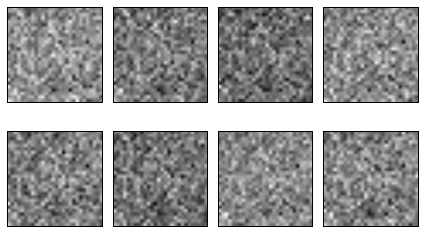

epoch: 50 -- loss G: [0.42101405560970306] - D: [1.3806013762950897]


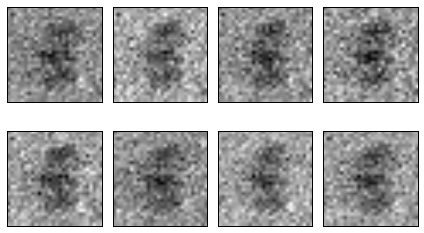

epoch: 100 -- loss G: [1.3782498836517334] - D: [1.0229222774505615]


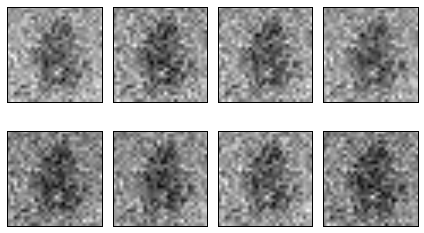

epoch: 150 -- loss G: [1.5249866843223572] - D: [0.36161255091428757]


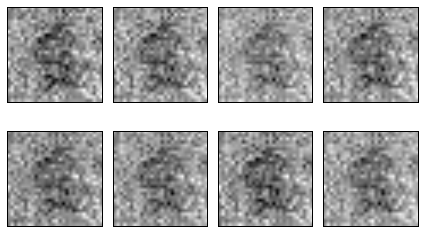

epoch: 200 -- loss G: [1.6672103404998779] - D: [0.31380631774663925]


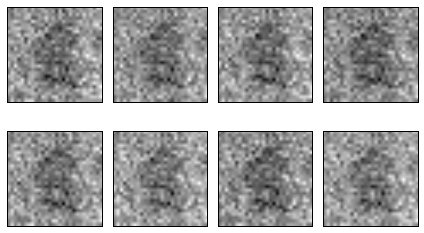

epoch: 250 -- loss G: [1.8287320137023926] - D: [0.28895880281925201]


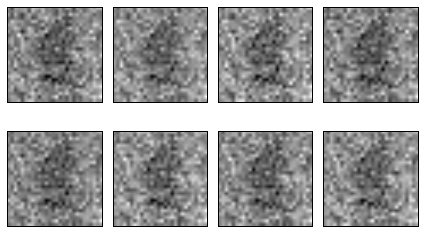

epoch: 300 -- loss G: [1.9064660668373108] - D: [0.27230417355895042]


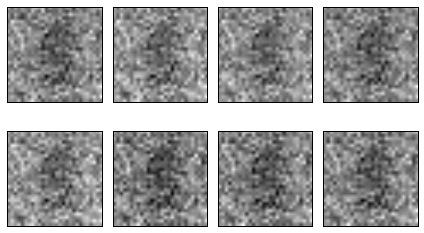

epoch: 350 -- loss G: [2.0293948650360107] - D: [0.26542039960622787]


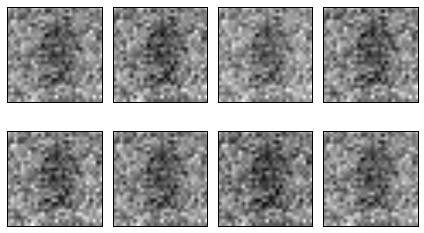

epoch: 400 -- loss G: [2.1339459419250488] - D: [0.26185612380504608]


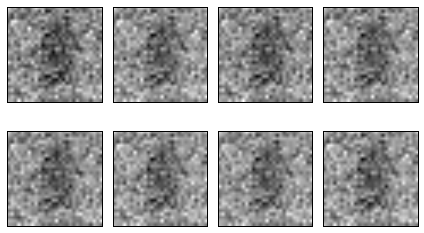

epoch: 450 -- loss G: [2.2045649290084839] - D: [0.24539894610643387]


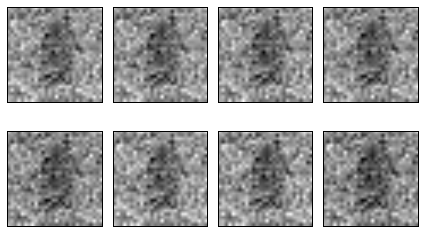

In [31]:
# setup experiment
max_epochs = 500
batch_size = 64
latent_space_size = data_dim
z_space = get_gaussian_space(-1, 1, latent_space_size)
generator, discriminator, gen_dis = get_mlp_model(latent_space_size)

# prepare data
gen_labels = np.random.uniform(0.8, 1.0, 2*batch_size)
gen_labels[:batch_size] = 0 #np.random.uniform(0.0, 0.3, batch_size)
gen_disc_labels = np.ones(batch_size) #np.random.uniform(1.0, batch_size)

g_losses = []
d_losses = []
for i in range(max_epochs):
    z_samples = z_space(batch_size).astype('float32')
    n = np.random.randint(0, data_count-batch_size-1)
    x_samples = data[n: n+batch_size].reshape(batch_size, -1)
    
    g_hist = gen_dis.fit(z_samples, gen_disc_labels, epochs=1, verbose=0)
    d_hist = discriminator.fit(np.vstack([generator.predict(z_samples), x_samples]),
                               gen_labels, epochs=1, verbose=0)
    
    g_losses.append(g_hist.history['loss'])
    d_losses.append(d_hist.history['loss'])
    
    if i % 50 == 0:
        print 'epoch: {} -- loss G: {} - D: {}'.format(i,g_hist.history['loss'], 
                                                       d_hist.history['loss'])
        z_samples = z_space(batch_size).astype('float32')
        fakes = generator.predict(z_samples[:8,:])
        plot_images(fakes, data_size)

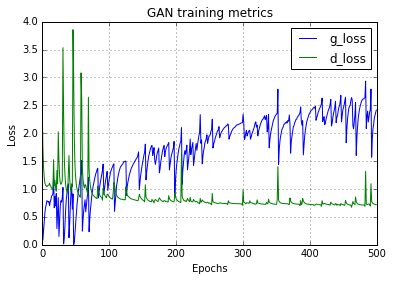

In [28]:
plot_performance(('g_loss', g_losses), ('d_loss', d_losses))